In [29]:
from math import log
import operator
import pickle
#计算香农熵
def calcShannonEnt(dataSet):
    numEntries = len(dataSet)
    labelCounts = {}
    for featVec in dataSet:    #为所有可能分类创建字典
        currentLabel = featVec[-1]     #类别在每项数据的最后一个
        labelCounts[currentLabel]=labelCounts.get(currentLabel,0) + 1 
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries   #每个对应标签的数量除以总数量，即公式中的p(x)
        shannonEnt -= prob*log(prob,2)   #以2为底求对数，因为每个前面都是负号，所以全部相加相当于-=
    return shannonEnt    #熵越高，则混合的数据就越多

#按照给定特征的值划分数据集(先去除给定的特征，返回按该特征分类后的数据集 )
def splitDataSet(dataSet, axis, value):   
    #axis:划分数据集的特征,相当于index即第几维，即第几个特征
    #value:需要返回的对应特征的值。
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis]    #要去掉的特征维数，把该特征之前的内容先保存
            reducedFeatVec.extend(featVec[axis+1:])  #把改特征之后的内容再保存，用extend
            retDataSet.append(reducedFeatVec)   #每一项数据处理完后以一个整体append回去
    return retDataSet      #返回一个划分之后的数据集                                                                                                                                                                                                                                                                                                                                                                                                                                                   

#选择最好的数据集划分方式
def chooseBestFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0]) - 1    #统计每项数据的特征数量，因为最后一列为标签值，所以-1
    baseEntropy = calcShannonEnt(dataSet) #先计算初始的信息熵
    bestInfoGain = 0.0;bestFeature = -1
    for i in range(numFeatures):        #创建唯一的分类标签列表
        featList = [example[i] for example in dataSet]   
        #使用列表推导创建新的列表。这里的意思是 分别提取每一项数据中的第i个特征作为一个list保存下来,即取得每个特征的不同取值
        #列表推导式（list comprehension）是利用其他列表创建新列表（类似于数学术语中的集合推导式）的一种方法
        #eg.  [x*x for x in range(10)]
        uniqueVals = set(featList)   #set集合类型下每个值不一样。【从列表中创建集合是python中得到列表唯一元素值的最快方法】
        newEntropy = 0.0
        for value in uniqueVals:        #遍历当前特征值中的所有唯一属性值，对每个属性值划分一次数据集，然后计算新熵值，并求和
            subDataSet = splitDataSet(dataSet, i, value) #划分之后的数据集
            prob = len(subDataSet)/float(len(dataSet))  #该对应特征取值下的一个数据集占总数据集的比例
            newEntropy += prob * calcShannonEnt(subDataSet)  #分别计算划分好之后的每个子数据集下的熵，然后按比例相乘后相加
        infoGain = baseEntropy - newEntropy #划分之后的熵变小了，所以用原始的减去划分之后的
        if (infoGain > bestInfoGain):       #计算最好的信息增益。即差值越大说明熵越小即越整齐
            bestInfoGain = infoGain
            bestFeature = i
    return bestFeature

#多数表决方法处理特殊情况：数据集处理完所有属性但类下面的标签依然不是唯一的
def majorityCnt(classList):
    classCount = {}
    for vote in classList:
        classCount[vote]=classCount.get(classCount[vote],0) + 1
    '''
        if vote not in classCount.keys():classCount[vote] = 0
        classCount[vote]+=1
    '''
    sortedClassCount = sorted(classCount.iteritems(),key=operator.itemgetter(1),reverse=True)
    #sort()与sorted()的不同在于，sort是在原位重新排列列表，而sorted()是产生一个新的列表。
    #dict.iteritems() 迭代返回键值对
    #key=operator.itemgetter(1) 按照对象的第1个域的值排序
    #reverse=True 降序排序
    return sortedClassCount[0][0]  #返回出现次数最多的分类名称

#创建树的函数代码
def createTree(dataSet,labels):
    # 坑 这里的labels不是y 而是不同特征的文字意思
    classList = [example[-1] for example in dataSet]    #获取每一项数据的最后一项，即类别
    if classList.count(classList[0]) == len(classList):  #如果类别列表中全是同一种，则返回
        return classList[0]
    if len(dataSet[0]) == 1:   #当只剩下一种特征时，通过多数表决方法获取出现次数的类别
        return majorityCnt(classList)
    bestFeat = chooseBestFeatureToSplit(dataSet) #获取最好的特征的序号
    bestFeatLabel = labels[bestFeat]        #获取对应的类别标签
    myTree = {bestFeatLabel:{}}         #第一个标签自然就是树的第一个分支了
    del(labels[bestFeat])       #从label中去掉用过的标签
    featValues = [example[bestFeat] for example in dataSet]   #得到列表该特征对应的所有属性值
    uniqueVals = set(featValues)  #去除重复
    for value in uniqueVals:
        subLabels = labels[:]   #复制了类标签，因为在python中函数参数是列表时，参数是按照引用的方式传递的
                                #为了保证每次调用函数createTree时不改变原始列表的内容，固使用新变量   
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet,bestFeat,value),subLabels)  #递归
    return myTree

#使用决策树的分类函数
def classify(inputTree,featLabels,testVec):
    firstStr = inputTree.keys()[0]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)   #将标签字符转换为索引/ 使用index方法查找当前列表中第一个匹配firstStr变量的元素
    for key in secondDict.keys():            #然后递归遍历整棵树，比较testVec变量中的值与树节点的值，若达到叶节点则返回当前叶节点分类标签
        if testVec[featIndex] == key:
            if type(secondDict[key]).__name__=='dict':
                classLabel = classify(secondDict[key],featLabels,testVec)
            else:classLabel = secondDict[key]
    return classLabel



In [30]:
import matplotlib.pyplot as plt

decisionNode = dict(boxstyle="sawtooth",fc="0.8")  #声明字典的一种新方式
leafNode = dict(boxstyle="round4",fc="0.8")
arrow_args = dict(arrowstyle="<-")      #定义文本框和箭头样式

#绘制带箭头的注解
def plotNode(nodeTxt,centerPt,parentPt,nodeType):
    createPlot.axl.annotate(nodeTxt,xy=parentPt,xycoords='axes fraction',\
                            xytext=centerPt,textcoords='axes fraction',\
                            va="center",ha="center",bbox=nodeType,arrowprops=arrow_args)

#在父子节点间填充文本信息
def plotMidText(cntrPt,parentPt,txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.axl.text(xMid,yMid,txtString)

#
def plotTree(myTree,parentPt,nodeTxt):
    numLeafs = getNumLeafs(myTree)
    depth = getTreeDepth(myTree)    #计算宽与高
    firstStr = list(myTree.keys())[0]
    cntrPt = (plotTree.xOff +(1.0+float(numLeafs))/2.0/plotTree.totalW,plotTree.yOff)  #全局变量plotTree.xOff/.yOff追踪已经绘制的节点位置 
    plotMidText(cntrPt,parentPt,nodeTxt)   #标记子节点属性值
    plotNode(firstStr,cntrPt,parentPt,decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD   #减少y偏移
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            plotTree(secondDict[key],cntrPt,str(key))
        else:
            plotTree.xOff = plotTree.xOff +1.0/plotTree.totalW
            plotNode(secondDict[key],(plotTree.xOff,plotTree.yOff),cntrPt,leafNode)
            plotMidText((plotTree.xOff,plotTree.yOff),cntrPt,str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD


def createPlot(inTree):
    fig = plt.figure(1,facecolor='white')
    fig.clf()
    axprops = dict(xticks=[],yticks=[])
    createPlot.axl = plt.subplot(111,frameon=False,**axprops)
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0;  #设置根节点在y轴1.0，x轴宽度的1/2处
    plotTree(inTree,(0.5,1.0),'')
    plt.show()

#获取叶节点的数目
def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]  #dict.keys()返回字典中所有关键字组成的list
    secondDict = myTree[firstStr] #因为子树下都是从0,1开始，所以这里可以当做关键字 参看49行
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':    #测试节点数据类型是否为字典,可通过__name__访问
            numLeafs += getNumLeafs(secondDict[key])  #递归
        else: numLeafs+=1
    return numLeafs

#获取树的层数
def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]   
    secondDict = myTree[firstStr] 
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:thisDepth = 1
        if thisDepth > maxDepth:maxDepth = thisDepth
    return maxDepth


{'tearRate': {'normal': {'astigmatic': {'no': {'age': {'young': 'soft', 'presbyopic': {'prescript': {'myope': 'no lenses', 'hyper': 'soft'}}, 'pre': 'soft'}}, 'yes': {'prescript': {'myope': 'hard', 'hyper': {'age': {'young': 'hard', 'presbyopic': 'no lenses', 'pre': 'no lenses'}}}}}}, 'reduced': 'no lenses'}}


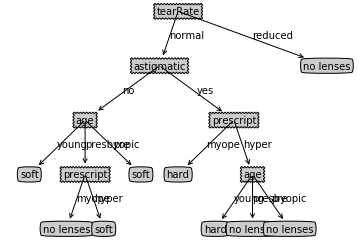

In [33]:
import sys

#预测隐形眼镜类型
fr=open(r'F:\data\lenses.txt')
lenses = [inst.strip().split('\t') for inst in fr.readlines()]
lensesLabels = ['age','prescript','astigmatic','tearRate']
lensesTree = createTree(lenses,lensesLabels)
print(lensesTree)
createPlot(lensesTree)